In [1]:
from __future__ import division
import numpy as np
import decimal
import pandas as pd
import matplotlib.axis as ax
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import scipy.stats 
import scipy.spatial as sp
import math
from scipy.special import expit

#Extracting datasets
file = pd.read_csv(r'C:\Users\gacevedo2016\Downloads\Titanic-MP2.csv') 
data = file.to_numpy()

#one-hot encoding sex, (female = [1,0], male = [0,1])
sex = data[:,4]
ohsex = np.zeros((891,2))
for i in range(len(sex)):
    if sex[i] == 'female':
        ohsex[i] = [1, 0]
    elif sex[i] == 'male':
        ohsex[i] = [0, 1]
    else:
        ohsex[i] = ['nan', 'nan'] 

#one-hot encoding pclass, (1 = [1,0,0], 2 = [0,1,0], 3=[0,0,1])
pclass = data[:,2]
ohpclass = np.zeros((891,3))
for i in range(len(pclass)):
    if pclass[i] == 1:
        ohpclass[i] = [1, 0, 0]
    elif pclass[i] == 2:
        ohpclass[i] = [0, 1, 0]
    elif pclass[i] == 3:
        ohpclass[i] = [0, 0, 1]
    else:
        ohpclass[i] = ['nan', 'nan', 'nan'] 

#one-hot encoding pclass, (C = [1,0,0], S = [0,1,0], Q=[0,0,1])
emb = data[:,11]
ohemb = np.zeros((891,3))
for i in range(len(emb)):
    if emb[i] == 'C':
        ohemb[i] = [1, 0, 0]
    elif emb[i] == 'S':
        ohemb[i] = [0, 1, 0]
    elif emb[i] == 'Q':
        ohemb[i] = [0, 0, 1]
    else:
        ohemb[i] = ['nan','nan','nan']

#Removing passengerId, Name, Ticket, Cabin
dataset = np.array((data[:,1], ohpclass[:,0], ohpclass[:,1], ohpclass[:,2], ohsex[:,0], ohsex[:,1], data[:,5], data[:,6], data[:,7], data[:,9], ohemb[:,0], ohemb[:,1], ohemb[:,2])).T 

#Removing rows with missing features 
dset = []
missing = []
for i in range(len(dataset)):
    if any(pd.isnull(dataset[i])):
        missing.append(dataset[i])
    else:
        dset.append(dataset[i])
missing = np.array(missing)
dset = np.array(dset)

#Training data set N = 250, validation and testing N = 231
dtr = dset[0:250, :]
dval = dset[250:481, :]
dtest = dset[481:712, :]

#Xtr (250X(12+1)) and ytrain (250X1)
#Xval (231X(12+1)) and yval (231X1)
#Xtest (231X(12+1)) and ytest (231X1)
#X[:,0:3] = pclass (0, 1, 2)
#X[:,3:5] = sex (3, 4)
#X[:,5:6] = age (5)
#X[:,6:7] = Sibsp (6)
#X[:,7:8] = Parch (7)
#X[:,8:9] = Fare (8)
#X[:,9:12] = Embark (9, 10, 11)
#D = 12

Xtr = np.concatenate((dtr[:, 1:13], np.ones((250,1))), axis=-1) #250X13
ytr = dtr[:,0:1] #250X1

Xval = np.concatenate((dval[:, 1:13], np.ones((231,1))), axis=-1) #231X13
yval = dval[:,0:1] #231x1

Xtest = np.concatenate((dtest[:, 1:13], np.ones((231,1))), axis=-1) #231X13
ytest = dtest[:,0:1] #231x1

#### Data summary
Now, we have D = 7 and total N = 712

* pclass $ \in R^3 \to $ one-hot encoded  
    * [1, 0, 0] = 1
    * [0, 1, 0] = 2
    * [0, 0, 1] = 3
* sex $ \in R^2  \to $ one-hot encoded 
    * [1, 0] = F
    * [0, 1] = M
* age 
* Sibsp 
* parch 
* fare 
* embark $ \in R^3  \to $ one-hot encoded 
    * [1, 0, 0] = C
    * [0, 1, 0] = S
    * [0, 0, 1] = Q

For training, we have N = 250

For validation and testing, we have N = 231

Computing the softmax(x) 

In [2]:
#x E R^D
#w E R^(DXC)
#h E R^C
#s E R
def modsoftmax(x, w):
    wt = w.T   #2x13
    h = np.dot(wt,x)  #2x1
    h = h.astype('float64')
    mexp = np.exp(h - np.max(h))
    den = np.sum(mexp)
    s = (mexp/den)
    return s  #2x1

Computing CE loss(x) and ACE(X)

In [3]:
#s - s(x) - Cx1
#y - one-hot for x label - CX1
#loss - (-log(Sy))
def CEloss (s, y):
    logs = -np.log(s)
    loss = np.dot(y.T, logs)
    return loss

#S - [s(x)^T] - R^NxC
#T - [t(x)^T] - R^NxC
def ACEloss (S, T, N):
    ACEl = 0
    for i in range(N):
        loss = CEloss(S.T[:,i:i+1], T.T[:,i:i+1])
        ACEl = ACEl + loss
    ACEloss = (1/N)*ACEl
    return ACEloss

One-Hot Encoding for labels (y)

In [4]:
def onehot (c, labels, y):
    T = np.zeros((len(y),c))
    lb = np.array(labels)
    t = np.zeros((c,c))
    
    for i in range(c):
        t[i,i] = 1
    
    for i in range(len(y)):
        for j in range(c):
            if y [i] == lb [j]:
                T[i] = t[j]
    for i in range(c):
        print('Class',lb[i], 'is', t[i])
    return T,t

Computing Gradient Descent for MNR 

In [5]:
def gdCE (X, T, N, D, C, rate = 0.1, iterations=1000):
    w = np.zeros((D,C))
    S = np.empty((N,C))
    ACE = np.empty((iterations,1))
    for i in range(iterations):
        for j in range(N):
            s = modsoftmax(X.T[:,j:j+1],w)
            S[j] = s.T
        ACE[i] = ACEloss(S, T, N)
        dACE = (1/N)*(X.T@(S-T))
        rdACE = (rate)*dACE
        wnew = w - rdACE
        Whist = np.vstack((w, wnew))
        w = wnew
    print('Done')
    return w, ACE


In [103]:
Ttr, t = onehot(2,(1,0),ytr)

Class 1 is [1. 0.]
Class 0 is [0. 1.]


Text(0.5, 1.0, 'Rate: 0.1, Iterations: 10,000')

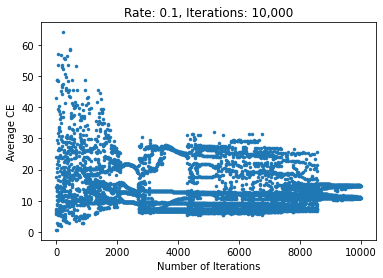

In [131]:
#w10, ACE10 = gdCE (Xtr, Ttr, 250, 13, 2, rate = 0.1, iterations=10000)
itera10 = np.arange(0,10000,1)
plt.scatter(itera10, ACE10, linewidths=0.5, marker='.')
plt.xlabel('Number of Iterations')
plt.ylabel('Average CE')
plt.title('Rate: 0.1, Iterations: 10,000')

<ipython-input-3-a85ced2a1adc>:5: RuntimeWarning: divide by zero encountered in log
  logs = -np.log(s)


Done


Text(0.5, 1.0, 'Rate: 0.1, Iterations: 50,000')

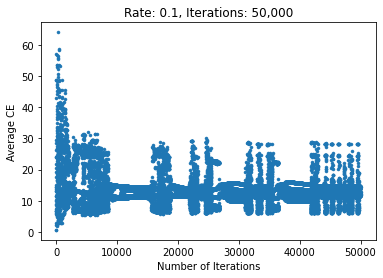

In [142]:
w50, ACE50 = gdCE (Xtr, Ttr, 250, 13, 2, rate = 0.1, iterations=50000)
itera50 = np.arange(0,50000,1)
plt.scatter(itera50, ACE50, linewidths=0.5, marker='.')
plt.xlabel('Number of Iterations')
plt.ylabel('Average CE')
plt.title('Rate: 0.1, Iterations: 50,000')

Text(0.5, 1.0, 'Rate: 0.03, Iterations: 10,000')

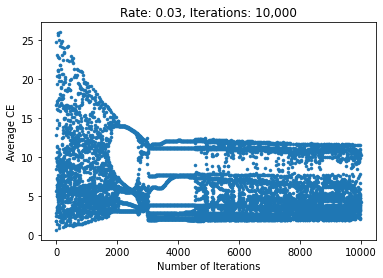

In [133]:
#w0, ACE0 = gdCE (Xtr, Ttr, 250, 13, 2, rate = 0.03, iterations=10000)
itera0 = np.arange(0,10000,1)
plt.scatter(itera0, ACE0, linewidths=0.5, marker='.')
plt.xlabel('Number of Iterations')
plt.ylabel('Average CE')
plt.title('Rate: 0.03, Iterations: 10,000')

Text(0.5, 1.0, 'Rate: 0.01, Iterations: 25,000')

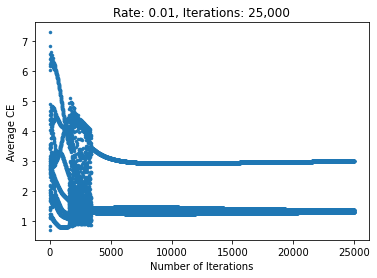

In [134]:
#w1, ACE1 = gdCE (Xtr, Ttr, 250, 13, 2, rate = 0.01, iterations=25000)
itera1 = np.arange(0,25000,1)
plt.scatter(itera1, ACE1, linewidths=0.5, marker='.')
plt.xlabel('Number of Iterations')
plt.ylabel('Average CE')
plt.title('Rate: 0.01, Iterations: 25,000')

In [111]:
#x E R^D
#w E R^(DXC)
#h E R^C
#s E R
Str = np.zeros((250,2))
for i in range(250):
    s = modsoftmax(Xtr.T[:,i:i+1], w10)
    Str[i] = s.T

predtr = np.zeros((250,1))
for i in range(250):
    if Str[i,0]>Str[i,1]:
        predtr[i]=1
    elif Str[i,0]<Str[i,1]:
        predtr[i]=0
    else:
        predtr[i] = 'NaN'
        print('softmax for x',i,'NaN')

loss = predtr == ytr
sum01 = 0
for i in range(len(ytr)):
    if loss[i] == False:
        sum01 = sum01 + 1
    else:
        sum01 = sum01
aloss01 = sum01/250
print('Learning Rate: 0.1', '\n Number of Iterations: 10,000','\n Missclassified samples:',sum01,'\n Average 0/1 Loss:', aloss01)


Learning Rate: 0.1 
 Number of Iterations: 10,000 
 Missclassified samples: 62 
 Average 0/1 Loss: 0.248


In [140]:
Str = np.zeros((250,2))
for i in range(250):
    s = modsoftmax(Xtr.T[:,i:i+1], w50)
    Str[i] = s.T

predtr = np.zeros((250,1))
for i in range(250):
    if Str[i,0]>Str[i,1]:
        predtr[i]=1
    elif Str[i,0]<Str[i,1]:
        predtr[i]=0
    else:
        predtr[i] = 'NaN'
        print('softmax for x',i,'NaN')

loss = predtr == ytr
sum01 = 0
for i in range(len(ytr)):
    if loss[i] == False:
        sum01 = sum01 + 1
    else:
        sum01 = sum01
aloss01 = sum01/250
print('Learning Rate: 0.1', '\n Number of Iterations: 50,000','\n Missclassified samples:',sum01,'\n Average 0/1 Loss:', aloss01)

TNtr = 0
TPtr = 0 
FPtr = 0
FNtr = 0
for i in range(len(Xtr)):
    if loss[i] == True:
        if ytr[i] == 1:
            TPtr = TPtr + 1
        elif ytr[i] == 0:
            TNtr = TNtr + 1
    elif loss[i] == False:
        if ytr[i] == 1:
            FNtr = FNtr + 1
        elif ytr[i] == 0:
            FPtr = FPtr + 1
print('TNtr:', TNtr, '\n TPtr:', TPtr, '\n FPtr:', FPtr, '\n FNtr:', FNtr)

Learning Rate: 0.1 
 Number of Iterations: 50,000 
 Missclassified samples: 60 
 Average 0/1 Loss: 0.24
TNtr: 104 
 TPtr: 86 
 FPtr: 41 
 FNtr: 19


In [113]:
Str = np.zeros((250,2))
for i in range(250):
    s = modsoftmax(Xtr.T[:,i:i+1], w0)
    Str[i] = s.T

predtr = np.zeros((250,1))
for i in range(250):
    if Str[i,0]>Str[i,1]:
        predtr[i]=1
    elif Str[i,0]<Str[i,1]:
        predtr[i]=0
    else:
        predtr[i] = 'NaN'
        print('softmax for x',i,'NaN')

loss = predtr == ytr
sum01 = 0
for i in range(len(ytr)):
    if loss[i] == False:
        sum01 = sum01 + 1
    else:
        sum01 = sum01
aloss01 = sum01/250
print('Learning Rate: 0.03', '\n Number of Iterations: 10,000','\n Missclassified samples:',sum01,'\n Average 0/1 Loss:', aloss01)

Learning Rate: 0.03 
 Number of Iterations: 10,000 
 Missclassified samples: 72 
 Average 0/1 Loss: 0.288


In [114]:
Str = np.zeros((250,2))
for i in range(250):
    s = modsoftmax(Xtr.T[:,i:i+1], w1)
    Str[i] = s.T

predtr = np.zeros((250,1))
for i in range(250):
    if Str[i,0]>Str[i,1]:
        predtr[i]=1
    elif Str[i,0]<Str[i,1]:
        predtr[i]=0
    else:
        predtr[i] = 'NaN'
        print('softmax for x',i,'NaN')

loss = predtr == ytr
sum01 = 0
for i in range(len(ytr)):
    if loss[i] == False:
        sum01 = sum01 + 1
    else:
        sum01 = sum01
aloss01 = sum01/250
print('Learning Rate: 0.01', '\n Number of Iterations: 25000','\n Missclassified samples:',sum01,'\n Average 0/1 Loss:', aloss01)

Learning Rate: 0.01 
 Number of Iterations: 25000 
 Missclassified samples: 64 
 Average 0/1 Loss: 0.256


In [119]:
def predicMNR (X, w, c):
    N = len(X)
    D = len(w)
    Spr = np.empty((N,c))
    for i in range(N):
        sp = modsoftmax(X.T[:,i:i+1], w)
        Spr[i] = sp.T
    return Spr

In [138]:
w = w50
Sval = predicMNR (Xval, w, 2)

predval = np.zeros((len(Xval),1))
for i in range(len(Xval)):
    if Sval[i,0]>Sval[i,1]:
        predval[i]=1
    elif Sval[i,0]<Sval[i,1]:
        predval[i]=0
    else:
        predval[i] = 'NaN'
        print('softmax for x',i,'NaN')

lossval = predval == yval
sumv01 = 0
for i in range(len(yval)):
    if lossval[i] == False:
        sumv01 = sumv01 + 1
    else:
        sumv01 = sumv01
alossv01 = sumv01/len(Xval)
print('Missclassified samples:',sumv01, 'of', len(Xval), '\n Average 0/1 Loss:', alossv01)

TNv = 0
TPv = 0 
FPv = 0
FNv = 0
for i in range(len(Xval)):
    if lossval[i] == True:
        if yval[i] == 1:
            TPv = TPv + 1
        elif yval[i] == 0:
            TNv = TNv + 1
    elif lossval[i] == False:
        if yval[i] == 1:
            FNv = FNv + 1
        elif yval[i] == 0:
            FPv = FPv + 1
print('TNv:', TNv, '\n TPv:', TPv, '\n FPv:', FPv, '\n FNv:', FNv)
            

Missclassified samples: 53 of 231 
 Average 0/1 Loss: 0.22943722943722944
TNv: 96 
 TPv: 82 
 FPv: 37 
 FNv: 16


In [139]:
w = w50
Stest = predicMNR (Xtest, w, 2)

predtest = np.zeros((len(Xtest),1))
for i in range(len(Xtest)):
    if Stest[i,0]>Stest[i,1]:
        predtest[i]=1
    elif Stest[i,0]<Stest[i,1]:
        predtest[i]=0
    else:
        predtest[i] = 'NaN'
        print('softmax for x',i,'NaN')

losstest = predtest == ytest
sumt01 = 0
for i in range(len(ytest)):
    if losstest[i] == False:
        sumt01 = sumt01 + 1
    else:
        sumt01 = sumt01
alosst01 = sumt01/len(Xtest)
print('Missclassified samples:',sumt01, 'of', len(Xtest), '\n Average 0/1 Loss:', alosst01)

TNt = 0
TPt = 0 
FPt = 0
FNt = 0
for i in range(len(Xtest)):
    if losstest[i] == True:
        if ytest[i] == 1:
            TPt = TPt + 1
        elif ytest[i] == 0:
            TNt = TNt + 1
    elif losstest[i] == False:
        if ytest[i] == 1:
            FNt = FNt + 1
        elif ytest[i] == 0:
            FPt = FPt + 1
print('TNt:', TNt, '\n TPt:', TPt, '\n FPt:', FPt, '\n FNt:', FNt)

Missclassified samples: 51 of 231 
 Average 0/1 Loss: 0.22077922077922077
TNt: 110 
 TPt: 70 
 FPt: 36 
 FNt: 15


### Task 3
#### (c) weight vector difference

In [157]:
wdif = (w50[:,0]-w50[:,1])
pclassdif = wdif[0:3]
print('Pclass weight vector difference:',pclassdif)
sexdif = wdif[3:5]
print('Sex weight vector difference:',sexdif)
agedif = wdif[5:6]
print('Age weight vector difference:',agedif)
sibspdif = wdif[6:7]
print('Sibsp weight vector difference:',sibspdif)
parchdif = wdif[7:8]
print('Parch weight vector difference:',parchdif)
faredif = wdif[8:9]
print('Fare weight vector difference:',faredif)
embarkdif = wdif[9:12]
print('Embark weight vector difference:',embarkdif)
bdif = wdif[12:13]
print('Intercept term weight vector difference:',bdif)

Pclass weight vector difference: [26.289932422248906 -3.74368223749504 -7.011390593378122]
Sex weight vector difference: [49.352234686504936 -33.81737509513806]
Age weight vector difference: [-1.2010320580199667]
Sibsp weight vector difference: [-17.130234627483674]
Parch weight vector difference: [-0.410631537927428]
Fare weight vector difference: [1.3600710036380117]
Embark weight vector difference: [2.19214870408858 11.265339253607172 2.077371633680133]
Intercept term weight vector difference: [15.534859591375517]


### Task 4
#### (a) Radial Basis Function Transformation

In [189]:
decimal.getcontext().prec = 100

def radialbasis (X, s):
    N = len(X)
    radtransformation = np.empty((N,1))
    for i in range(N):
        dist = np.linalg.norm(X.T - X.T[:,i:i+1]) 
        ex = np.exp(-dist/s)
        radtransformation[i]=ex
    return radtransformation
        

In [188]:
np.linalg.norm(Xval.T - Xval.T[:,0:1])

1007.5166702964971

In [190]:
rXtr = radialbasis(Xtr, 1.0)
rXval = radialbasis(Xval, 1.0)

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],